In [19]:
import pandas as pd
import numpy as np
import re
import os
import sys

sys.path.append(os.path.relpath("../src/"))
from dataloader import S1, S2, S3, S4
import emg
from utils import create_sliding_window_features 
from multilabel import MultilabelPredictor
from autogluon.tabular import TabularDataset, TabularPredictor

In [21]:
import logging, datetime

log_format = '%(asctime)s [%(levelname)s] %(message)s'
log_filename = datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
logging.basicConfig(format=log_format, 
                    force=True,
                    handlers=[
                        logging.FileHandler(f"../log/{log_filename}.log"),
                        logging.StreamHandler()
                        ],
                    level=logging.INFO
                    )

### data splitter

In [16]:
feature_path_prefix = '../features/scenario_1/train/'
annotation_path_prefix = '../data/scenario_1/train/annotations/'
save_prefix = '../splitted_data/feature/'
s1 = S1()

validation_pairs = []
for sub in s1.train_subs[::5]:
    for vid in s1.train_vids[::2]:
        validation_pairs.append((sub, vid))
        
for sub, vid in validation_pairs:
    features = pd.read_csv(os.path.join(feature_path_prefix, f'sub_{sub}_vid_{vid}.csv'), index_col='time')
    annotations = pd.read_csv(os.path.join(annotation_path_prefix, f'sub_{sub}_vid_{vid}.csv'), index_col='time')
    
    df = pd.concat([features, annotations], axis=1)
    
    length = len(df)
    
    train_length = int(length * 0.8)
    test_length = length - train_length

    # train_data = df[:train_length]
    # test_data = df[train_length:]
    df[:train_length].to_csv(os.path.join(save_prefix, 'scenario_1/train', f'sub_{sub}_vid_{vid}.csv'), index_label='time')
    df[train_length:].to_csv(os.path.join(save_prefix, 'scenario_1/test', f'sub_{sub}_vid_{vid}.csv'), index_label='time')

### training on featrues

In [31]:
save_prefix = '../splitted_data/feature/'
label = 'arousal'

subjectID = []
videoID = []

root_mean_squared_error = []

list_predictions = []

for sub, vid in validation_pairs:
    subjectID.append(sub)
    videoID.append(vid)
    
    train_data = TabularDataset(os.path.join(save_prefix, f'scenario_1/train', f'sub_{sub}_vid_{vid}.csv'))
    train_data = train_data.fillna(0)
    train_data = train_data.drop(columns=['valence'])
    predictor = TabularPredictor(label=label, problem_type='regression', path=f'AutogluonModels/scenario_1/model/feature_sub_vid_dependent/sub_{sub}_vid_{vid}_arousal', verbosity=0).fit(train_data, ag_args_fit={'num_gpus': 1})
    
    predictor = TabularPredictor.load(f'AutogluonModels/scenario_1/model/feature_sub_vid_dependent/sub_{sub}_vid_{vid}_arousal')

    test_data = TabularDataset(os.path.join(save_prefix, f'scenario_1/test', f'sub_{sub}_vid_{vid}.csv'))
    y_test = test_data[label]
    test_data_nolab = test_data.drop(columns=[label, 'valence'])
    test_data_nolab = test_data_nolab.fillna(0)

    
    y_pred = predictor.predict(test_data_nolab)
    subjectID_pred = []
    videoID_pred = []
    
    for i in range(len(y_pred)):
        subjectID_pred.append(sub)
        videoID_pred.append(vid)
    
    predictions_dataframe = pd.DataFrame({'subjectID': subjectID_pred, 'videoID': videoID_pred, 'y_true': y_test, 'y_pred': y_pred})
    
    list_predictions.append(predictions_dataframe)
        
    rmse = np.sqrt(((y_pred - y_test) ** 2).mean())
    logging.info(f'Sub {sub} Vid {vid} RMSE: {rmse}')

    root_mean_squared_error.append(rmse)
    perf = predictor.evaluate_predictions(y_true=y_test, y_pred=y_pred, auxiliary_metrics=True)

evaluation_dataframe = pd.DataFrame({'subjectID': subjectID, 'videoID': videoID, 'root_mean_squared_error': root_mean_squared_error})

evaluation_dataframe.to_csv(f'AutogluonModels/scenario_1/output/comparison_feature_rmse_arousal_fillna.csv')
pd.concat(list_predictions, axis=0).to_csv(f'AutogluonModels/scenario_1/output/comparison_feature_prediction_arousal_fillna.csv')

2023-04-24 12:40:06,643 [INFO] Sub 1 Vid 1 RMSE: 0.1851099159556773
2023-04-24 12:41:15,597 [INFO] Sub 1 Vid 10 RMSE: 0.025752402418878502
2023-04-24 12:41:56,640 [INFO] Sub 1 Vid 13 RMSE: 0.2738819557568927
2023-04-24 12:43:02,990 [INFO] Sub 1 Vid 18 RMSE: 0.5946329671266043
2023-04-24 12:43:57,380 [INFO] Sub 9 Vid 1 RMSE: 0.29909925614763105
2023-04-24 12:44:25,553 [INFO] Sub 9 Vid 10 RMSE: 0.3089960405609499
2023-04-24 12:45:04,493 [INFO] Sub 9 Vid 13 RMSE: 0.37788345874908663
2023-04-24 12:45:51,406 [INFO] Sub 9 Vid 18 RMSE: 0.8835045665019308
2023-04-24 12:46:46,807 [INFO] Sub 17 Vid 1 RMSE: 0.41414103725275375
2023-04-24 12:47:44,898 [INFO] Sub 17 Vid 10 RMSE: 0.1164221118684602
/usr/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
2023-04-24 12:48:15,190 [INFO] Sub 17 Vid 13 RMSE: 0.6138101020146132
2023-04-24 12:50:09,563 [INF

In [28]:
save_prefix = '../splitted_data/feature/'
label = 'valence'

subjectID = []
videoID = []

root_mean_squared_error = []

list_predictions = []

for sub, vid in validation_pairs:
    subjectID.append(sub)
    videoID.append(vid)
    
    train_data = TabularDataset(os.path.join(save_prefix, f'scenario_1/train', f'sub_{sub}_vid_{vid}.csv'))
    train_data = train_data.fillna(0)
    train_data = train_data.drop(columns=['arousal'])
    predictor = TabularPredictor(label=label, problem_type='regression', path=f'AutogluonModels/scenario_1/model/feature_sub_vid_dependent/sub_{sub}_vid_{vid}_valence', verbosity=0).fit(train_data, ag_args_fit={'num_gpus': 1})
    
    predictor = TabularPredictor.load(f'AutogluonModels/scenario_1/model/feature_sub_vid_dependent/sub_{sub}_vid_{vid}_valence')

    test_data = TabularDataset(os.path.join(save_prefix, f'scenario_1/test', f'sub_{sub}_vid_{vid}.csv'))
    y_test = test_data[label]
    test_data_nolab = test_data.drop(columns=[label, 'arousal'])
    test_data_nolab = test_data_nolab.fillna(0)
    
    y_pred = predictor.predict(test_data_nolab)
    subjectID_pred = []
    videoID_pred = []
    
    for i in range(len(y_pred)):
        subjectID_pred.append(sub)
        videoID_pred.append(vid)
    
    predictions_dataframe = pd.DataFrame({'subjectID': subjectID_pred, 'videoID': videoID_pred, 'y_true': y_test, 'y_pred': y_pred})
    
    list_predictions.append(predictions_dataframe)
        
    rmse = np.sqrt(((y_pred - y_test) ** 2).mean())
    logging.info(f'Sub {sub} Vid {vid} RMSE: {rmse}')

    root_mean_squared_error.append(rmse)
    perf = predictor.evaluate_predictions(y_true=y_test, y_pred=y_pred, auxiliary_metrics=True)
    print(rmse, perf['root_mean_squared_error'])

evaluation_dataframe = pd.DataFrame({'subjectID': subjectID, 'videoID': videoID, 'root_mean_squared_error': root_mean_squared_error})

evaluation_dataframe.to_csv(f'AutogluonModels/scenario_1/output/comparison_feature_rmse_valence.csv')
pd.concat(list_predictions, axis=0).to_csv(f'AutogluonModels/scenario_1/output/comparison_feature_prediction_valence.csv')

2023-04-24 11:32:08,885 [INFO] Sub 1 Vid 1 RMSE: 0.13708393460961033


0.13708393460961033 -0.13708393460961033


2023-04-24 11:32:52,352 [INFO] Sub 1 Vid 10 RMSE: 0.0031445821566913517
/usr/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


0.0031445821566913517 -0.0031445821566913517


2023-04-24 11:33:45,538 [INFO] Sub 1 Vid 13 RMSE: 0.14189398211459692
/usr/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


0.14189398211459692 -0.14189398211459692


2023-04-24 11:34:38,149 [INFO] Sub 1 Vid 18 RMSE: 0.41489447238351723


0.41489447238351723 -0.41489447238351723


2023-04-24 11:36:53,651 [INFO] Sub 9 Vid 1 RMSE: 0.7776547223350357


0.7776547223350357 -0.7776547223350357


2023-04-24 11:37:26,169 [INFO] Sub 9 Vid 10 RMSE: 0.14366127903077267


0.14366127903077267 -0.14366127903077267


2023-04-24 11:37:53,425 [INFO] Sub 9 Vid 13 RMSE: 0.13491248436879605


0.13491248436879605 -0.13491248436879605


2023-04-24 11:38:38,625 [INFO] Sub 9 Vid 18 RMSE: 0.3888741586700516


0.3888741586700516 -0.3888741586700516


2023-04-24 11:39:26,328 [INFO] Sub 17 Vid 1 RMSE: 0.08102541187381572


0.08102541187381572 -0.08102541187381572


2023-04-24 11:40:37,424 [INFO] Sub 17 Vid 10 RMSE: 0.2054379948692579


0.2054379948692579 -0.2054379948692579


2023-04-24 11:41:18,534 [INFO] Sub 17 Vid 13 RMSE: 0.41532521837132597


0.41532521837132597 -0.41532521837132597


2023-04-24 11:42:27,041 [INFO] Sub 17 Vid 18 RMSE: 0.19832244388127368


0.19832244388127368 -0.19832244388127368


2023-04-24 11:43:02,497 [INFO] Sub 26 Vid 1 RMSE: 0.05310581549353405


0.05310581549353405 -0.05310581549353405


		catboost/libs/metrics/metric.cpp:6376: All train targets are equal
2023-04-24 11:43:05,581 [INFO] Sub 26 Vid 10 RMSE: 0.0
/usr/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


0.0 -0.0


2023-04-24 11:43:46,469 [INFO] Sub 26 Vid 13 RMSE: 0.21738049559376033


0.21738049559376033 -0.21738049559376033


2023-04-24 11:44:27,945 [INFO] Sub 26 Vid 18 RMSE: 0.9415684064354306


0.9415684064354306 -0.9415684064354306


2023-04-24 11:44:59,072 [INFO] Sub 32 Vid 1 RMSE: 0.4748489243199611


0.4748489243199611 -0.4748489243199611


2023-04-24 11:45:53,662 [INFO] Sub 32 Vid 10 RMSE: 0.2335365553489719


0.2335365553489719 -0.2335365553489719


2023-04-24 11:47:56,724 [INFO] Sub 32 Vid 13 RMSE: 0.7364821745410827


0.7364821745410827 -0.7364821745410827


2023-04-24 11:49:21,551 [INFO] Sub 32 Vid 18 RMSE: 0.9190222116940195


0.9190222116940195 -0.9190222116940195


2023-04-24 11:50:18,233 [INFO] Sub 37 Vid 1 RMSE: 0.053951835372846216
/usr/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


0.053951835372846216 -0.053951835372846216


2023-04-24 11:51:18,317 [INFO] Sub 37 Vid 10 RMSE: 0.012510618570989337


0.012510618570989337 -0.012510618570989337


		catboost/libs/metrics/metric.cpp:6376: All train targets are equal
2023-04-24 11:51:21,559 [INFO] Sub 37 Vid 13 RMSE: 0.01872006084301278
/usr/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


0.01872006084301278 -0.01872006084301278


2023-04-24 11:52:30,458 [INFO] Sub 37 Vid 18 RMSE: 0.9654805363561625


0.9654805363561625 -0.9654805363561625


### training on raw data

In [29]:
save_prefix = '../splitted_data/raw/'
label = 'arousal'

subjectID = []
videoID = []

root_mean_squared_error = []

list_predictions = []

for sub, vid in validation_pairs:
    subjectID.append(sub)
    videoID.append(vid)
    
    train_data = TabularDataset(os.path.join(save_prefix, f'scenario_1/train', f'sub_{sub}_vid_{vid}.csv'))
    train_data = train_data.fillna(0)
    train_data = train_data.drop(columns=['valence'])
    predictor = TabularPredictor(label=label, problem_type='regression', path=f'AutogluonModels/scenario_1/model/raw_sub_vid_dependent/sub_{sub}_vid_{vid}_arousal', verbosity=0).fit(train_data, ag_args_fit={'num_gpus': 1})
    
    predictor = TabularPredictor.load(f'AutogluonModels/scenario_1/model/raw_sub_vid_dependent/sub_{sub}_vid_{vid}_arousal')

    test_data = TabularDataset(os.path.join(save_prefix, f'scenario_1/test', f'sub_{sub}_vid_{vid}.csv'))
    y_test = test_data[label]
    test_data_nolab = test_data.drop(columns=[label, 'valence'])
    test_data_nolab = test_data_nolab.fillna(0)

    
    y_pred = predictor.predict(test_data_nolab)
    subjectID_pred = []
    videoID_pred = []
    
    for i in range(len(y_pred)):
        subjectID_pred.append(sub)
        videoID_pred.append(vid)
    
    predictions_dataframe = pd.DataFrame({'subjectID': subjectID_pred, 'videoID': videoID_pred, 'y_true': y_test, 'y_pred': y_pred})
    
    list_predictions.append(predictions_dataframe)
        
    rmse = np.sqrt(((y_pred - y_test) ** 2).mean())
    logging.info(f'Sub {sub} Vid {vid} RMSE: {rmse}')

    root_mean_squared_error.append(rmse)
    perf = predictor.evaluate_predictions(y_true=y_test, y_pred=y_pred, auxiliary_metrics=True)

evaluation_dataframe = pd.DataFrame({'subjectID': subjectID, 'videoID': videoID, 'root_mean_squared_error': root_mean_squared_error})

evaluation_dataframe.to_csv(f'AutogluonModels/scenario_1/output/comparison_raw_rmse_arousal.csv')
pd.concat(list_predictions, axis=0).to_csv(f'AutogluonModels/scenario_1/output/comparison_raw_prediction_arousal.csv')

2023-04-24 11:53:19,636 [INFO] Sub 1 Vid 1 RMSE: 0.09541738891226419
/usr/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
2023-04-24 11:53:59,207 [INFO] Sub 1 Vid 10 RMSE: 0.007864991204704762
2023-04-24 11:54:45,725 [INFO] Sub 1 Vid 13 RMSE: 0.05281377589840203
2023-04-24 11:55:46,467 [INFO] Sub 1 Vid 18 RMSE: 0.5432367325913394
2023-04-24 11:56:50,694 [INFO] Sub 9 Vid 1 RMSE: 0.1598567254748051
2023-04-24 11:59:10,513 [INFO] Sub 9 Vid 10 RMSE: 0.01492970394068426
2023-04-24 12:00:17,698 [INFO] Sub 9 Vid 13 RMSE: 0.05988446074520219
2023-04-24 12:01:22,537 [INFO] Sub 9 Vid 18 RMSE: 2.059422580378787
2023-04-24 12:02:03,687 [INFO] Sub 17 Vid 1 RMSE: 0.26978245970870235
2023-04-24 12:02:49,212 [INFO] Sub 17 Vid 10 RMSE: 9.346008322808076e-08
/usr/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An inpu

In [30]:
save_prefix = '../splitted_data/raw/'
label = 'valence'

subjectID = []
videoID = []

root_mean_squared_error = []

list_predictions = []

for sub, vid in validation_pairs:
    subjectID.append(sub)
    videoID.append(vid)
    
    train_data = TabularDataset(os.path.join(save_prefix, f'scenario_1/train', f'sub_{sub}_vid_{vid}.csv'))
    train_data = train_data.fillna(0)
    train_data = train_data.drop(columns=['arousal'])
    predictor = TabularPredictor(label=label, problem_type='regression', path=f'AutogluonModels/scenario_1/model/raw_sub_vid_dependent/sub_{sub}_vid_{vid}_valence', verbosity=0).fit(train_data, ag_args_fit={'num_gpus': 1})
    
    predictor = TabularPredictor.load(f'AutogluonModels/scenario_1/model/raw_sub_vid_dependent/sub_{sub}_vid_{vid}_valence')

    test_data = TabularDataset(os.path.join(save_prefix, f'scenario_1/test', f'sub_{sub}_vid_{vid}.csv'))
    y_test = test_data[label]
    test_data_nolab = test_data.drop(columns=[label, 'arousal'])
    test_data_nolab = test_data_nolab.fillna(0)

    
    y_pred = predictor.predict(test_data_nolab)
    subjectID_pred = []
    videoID_pred = []
    
    for i in range(len(y_pred)):
        subjectID_pred.append(sub)
        videoID_pred.append(vid)
    
    predictions_dataframe = pd.DataFrame({'subjectID': subjectID_pred, 'videoID': videoID_pred, 'y_true': y_test, 'y_pred': y_pred})
    
    list_predictions.append(predictions_dataframe)
        
    rmse = np.sqrt(((y_pred - y_test) ** 2).mean())
    logging.info(f'Sub {sub} Vid {vid} RMSE: {rmse}')

    root_mean_squared_error.append(rmse)
    perf = predictor.evaluate_predictions(y_true=y_test, y_pred=y_pred, auxiliary_metrics=True)

evaluation_dataframe = pd.DataFrame({'subjectID': subjectID, 'videoID': videoID, 'root_mean_squared_error': root_mean_squared_error})

evaluation_dataframe.to_csv(f'AutogluonModels/scenario_1/output/comparison_raw_rmse_valence.csv')
pd.concat(list_predictions, axis=0).to_csv(f'AutogluonModels/scenario_1/output/comparison_raw_prediction_valence.csv')

2023-04-24 12:19:37,032 [INFO] Sub 1 Vid 1 RMSE: 0.10441378924663655
2023-04-24 12:20:08,695 [INFO] Sub 1 Vid 10 RMSE: 1.258850099716824e-07
/usr/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
2023-04-24 12:20:38,644 [INFO] Sub 1 Vid 13 RMSE: 0.0033179392000418726
/usr/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
2023-04-24 12:22:07,759 [INFO] Sub 1 Vid 18 RMSE: 0.2827003011558666
2023-04-24 12:22:48,204 [INFO] Sub 9 Vid 1 RMSE: 0.12338436928655945
2023-04-24 12:23:25,962 [INFO] Sub 9 Vid 10 RMSE: 0.0020498669891767405
/usr/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  

### comparison

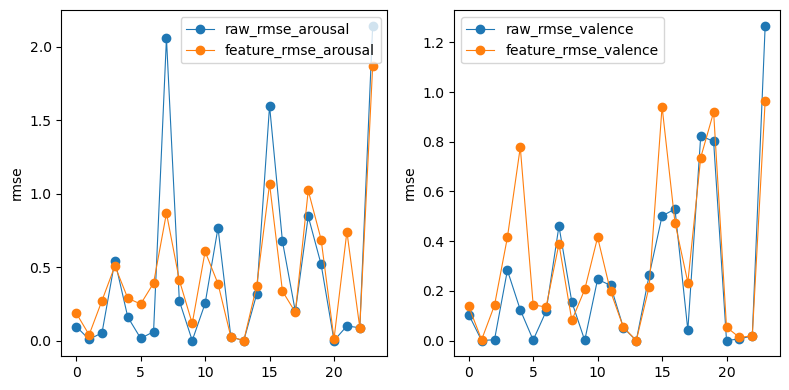

In [33]:
import matplotlib.pyplot as plt

s1 = S1()

validation_pairs = []
for sub in s1.train_subs[::5]:
    for vid in s1.train_vids[::2]:
        validation_pairs.append((sub, vid))

raw_rmse_arousal = pd.read_csv('AutogluonModels/scenario_1/output/comparison_raw_rmse_arousal.csv')
raw_rmse_valence = pd.read_csv('AutogluonModels/scenario_1/output/comparison_raw_rmse_valence.csv')
feature_rmse_arousal = pd.read_csv('AutogluonModels/scenario_1/output/comparison_feature_rmse_arousal.csv')
feature_rmse_valence = pd.read_csv('AutogluonModels/scenario_1/output/comparison_feature_rmse_valence.csv')

fig, axes = plt.subplots(1, 2, figsize=(8, 4))
axes = axes.flatten()
axes[0].set_ylabel('rmse')
axes[0].plot(raw_rmse_arousal['root_mean_squared_error'], 'o-', linewidth=0.8, label='raw_rmse_arousal')
axes[0].plot(feature_rmse_arousal['root_mean_squared_error'], 'o-', linewidth=0.8, label='feature_rmse_arousal')
axes[0].legend()

axes[1].set_ylabel('rmse')
axes[1].plot(raw_rmse_valence['root_mean_squared_error'], 'o-', linewidth=0.8, label='raw_rmse_valence')
axes[1].plot(feature_rmse_valence['root_mean_squared_error'], 'o-', linewidth=0.8, label='feature_rmse_valence')

plt.legend()
plt.tight_layout()
plt.show()

In [34]:
raw_rmse_arousal['root_mean_squared_error'].mean(), feature_rmse_arousal['root_mean_squared_error'].mean()

(0.4495746558801385, 0.447199111393996)

In [35]:
raw_rmse_valence['root_mean_squared_error'].mean(), feature_rmse_valence['root_mean_squared_error'].mean()

(0.25092245151177567, 0.3195349299681048)

### multi-label predictor on raw data

In [36]:
from multilabel import MultilabelPredictor

In [ ]:
save_prefix = '../splitted_data/raw/'

labels = ['arousal', 'valence']
s1 = S1()

subjectID = []
videoID = []

# root_mean_squared_error = []
list_predictions = []
arousal_rmse = []
valence_rmse = []
for sub, vid in validation_pairs:
    subjectID.append(sub)
    videoID.append(vid)
    
    train_data = TabularDataset(os.path.join(save_prefix, f'scenario_1/train', f'sub_{sub}_vid_{vid}.csv'))
    multi_predictor = MultilabelPredictor(labels=labels, problem_types=['regression', 'regression'], path=f'AutogluonModels/scenario_1/model/multilabel_raw_sub_vid_dependent/sub_{sub}_vid_{vid}_multilabel',
                                          eval_metrics=['root_mean_squared_error', 'rmse'], verbosity=0).fit(train_data, ag_args_fit={'num_gpus': 1}, presets='best_quality')

    multi_predictor = MultilabelPredictor.load(f'AutogluonModels/scenario_1/model/multilabel_raw_sub_vid_dependent/sub_{sub}_vid_{vid}_multilabel')
    
    test_data = TabularDataset(os.path.join(save_prefix, f'scenario_1/test', f'sub_{sub}_vid_{vid}.csv'))
    test_data_nolab = test_data.drop(columns=labels)
    
    predictions = multi_predictor.predict(test_data_nolab)

    subjectID_pred = []
    videoID_pred = []
    
    for i in range(len(predictions)):
        subjectID_pred.append(sub)
        videoID_pred.append(vid)
    arousal_rmse.append(np.sqrt(((predictions['arousal'] - test_data['arousal']) ** 2).mean()))
    valence_rmse.append(np.sqrt(((predictions['valence'] - test_data['valence']) ** 2).mean()))
    predictions.insert(len(predictions.columns), 'arousal_true', test_data['arousal'])
    predictions.insert(len(predictions.columns), 'valence_true', test_data['valence'])
    
    list_predictions.append(predictions)
    
    evaluations = multi_predictor.evaluate(test_data)
    print(evaluations)
    
evaluation_dataframe = pd.DataFrame({'subjectID': subjectID, 'videoID': videoID, 'arousal_rmse': arousal_rmse, 'valence_rmse': valence_rmse})
evaluation_dataframe.to_csv(f'AutogluonModels/scenario_1/output/comparison_raw_multi_label_rmse.csv')
pd.concat(list_predictions, axis=0).to_csv(f'AutogluonModels/scenario_1/output/comparison_raw_multi_label_predictions.csv')

Fitting TabularPredictor for label: arousal ...
Fitting TabularPredictor for label: valence ...
MultilabelPredictor saved to disk. Load with: MultilabelPredictor.load('AutogluonModels/scenario_1/model/multilabel_raw_sub_vid_dependent/sub_1_vid_1_multilabel/')
Predicting with TabularPredictor for label: arousal ...
Predicting with TabularPredictor for label: valence ...
Evaluating TabularPredictor for label: arousal ...


/home/celia/.local/lib/python3.10/site-packages/autogluon/tabular/predictor/predictor.py:1420: FutureWarning: Calling `predictor.predict_proba` when problem_type=regression will raise an AssertionError starting in AutoGluon v0.8. Please call `predictor.predict` instead.
  warnings.warn(


Evaluating TabularPredictor for label: valence ...
{'arousal': {'root_mean_squared_error': -0.09556738382839565, 'mean_squared_error': -0.009133124851803898, 'mean_absolute_error': -0.07120011433562139, 'r2': -1.165431264091069, 'pearsonr': 0.2896373112143108, 'median_absolute_error': -0.019417205810547067}, 'valence': {'root_mean_squared_error': -0.10434763780894651, 'mean_squared_error': -0.010888429516307085, 'mean_absolute_error': -0.07334817833704162, 'r2': -0.3773273043289467, 'pearsonr': 0.3586073308575066, 'median_absolute_error': -0.07114985275268548}}
Fitting TabularPredictor for label: arousal ...


/home/celia/.local/lib/python3.10/site-packages/autogluon/tabular/predictor/predictor.py:1420: FutureWarning: Calling `predictor.predict_proba` when problem_type=regression will raise an AssertionError starting in AutoGluon v0.8. Please call `predictor.predict` instead.
  warnings.warn(


Fitting TabularPredictor for label: valence ...
MultilabelPredictor saved to disk. Load with: MultilabelPredictor.load('AutogluonModels/scenario_1/model/multilabel_raw_sub_vid_dependent/sub_1_vid_10_multilabel/')
Predicting with TabularPredictor for label: arousal ...
Predicting with TabularPredictor for label: valence ...
Evaluating TabularPredictor for label: arousal ...
Evaluating TabularPredictor for label: valence ...


/home/celia/.local/lib/python3.10/site-packages/autogluon/tabular/predictor/predictor.py:1420: FutureWarning: Calling `predictor.predict_proba` when problem_type=regression will raise an AssertionError starting in AutoGluon v0.8. Please call `predictor.predict` instead.
  warnings.warn(
/usr/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/home/celia/.local/lib/python3.10/site-packages/autogluon/tabular/predictor/predictor.py:1420: FutureWarning: Calling `predictor.predict_proba` when problem_type=regression will raise an AssertionError starting in AutoGluon v0.8. Please call `predictor.predict` instead.
  warnings.warn(
/usr/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


{'arousal': {'root_mean_squared_error': -0.007791062651507217, 'mean_squared_error': -6.070065723971066e-05, 'mean_absolute_error': -0.007592787481080709, 'r2': -18.900205156413687, 'pearsonr': nan, 'median_absolute_error': -0.00799998855590811}, 'valence': {'root_mean_squared_error': -1.258850099716824e-07, 'mean_squared_error': -1.5847035735570575e-14, 'mean_absolute_error': -1.258850099716824e-07, 'r2': 0.0, 'pearsonr': nan, 'median_absolute_error': -1.258850099716824e-07}}
Fitting TabularPredictor for label: arousal ...
Fitting TabularPredictor for label: valence ...


In [ ]:
save_prefix = '../splitted_data/raw/'

labels = ['valence', 'arousal']
s1 = S1()

subjectID = []
videoID = []

# root_mean_squared_error = []
list_predictions = []
arousal_rmse = []
valence_rmse = []
for sub, vid in validation_pairs:
    subjectID.append(sub)
    videoID.append(vid)
    
    train_data = TabularDataset(os.path.join(save_prefix, f'scenario_1/train', f'sub_{sub}_vid_{vid}.csv'))
    multi_predictor = MultilabelPredictor(labels=labels, problem_types=['regression', 'regression'], path=f'AutogluonModels/scenario_1/model/multilabel_raw_sub_vid_dependent/sub_{sub}_vid_{vid}_multilabel_flip',
                                          eval_metrics=['root_mean_squared_error', 'rmse'], verbosity=0).fit(train_data, ag_args_fit={'num_gpus': 1}, presets='best_quality')

    multi_predictor = MultilabelPredictor.load(f'AutogluonModels/scenario_1/model/multilabel_raw_sub_vid_dependent/sub_{sub}_vid_{vid}_multilabel_flip')
    
    test_data = TabularDataset(os.path.join(save_prefix, f'scenario_1/test', f'sub_{sub}_vid_{vid}.csv'))
    test_data_nolab = test_data.drop(columns=labels)
    
    predictions = multi_predictor.predict(test_data_nolab)

    subjectID_pred = []
    videoID_pred = []
    
    for i in range(len(predictions)):
        subjectID_pred.append(sub)
        videoID_pred.append(vid)
    arousal_rmse.append(np.sqrt(((predictions['arousal'] - test_data['arousal']) ** 2).mean()))
    valence_rmse.append(np.sqrt(((predictions['valence'] - test_data['valence']) ** 2).mean()))
    predictions.insert(len(predictions.columns), 'arousal_true', test_data['arousal'])
    predictions.insert(len(predictions.columns), 'valence_true', test_data['valence'])
    
    list_predictions.append(predictions)
    
    evaluations = multi_predictor.evaluate(test_data)
    print(evaluations)
    
evaluation_dataframe = pd.DataFrame({'subjectID': subjectID, 'videoID': videoID, 'arousal_rmse': arousal_rmse, 'valence_rmse': valence_rmse})
evaluation_dataframe.to_csv(f'AutogluonModels/scenario_1/output/comparison_raw_multi_label_flip_rmse.csv')
pd.concat(list_predictions, axis=0).to_csv(f'AutogluonModels/scenario_1/output/comparison_raw_multi_label_flip_predictions.csv')

### training on preprocessed data